In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa
import IPython

In [3]:
import pickle
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device) 

device= cuda


In [4]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [5]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=32,padding= 1012,bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, padding= 1012,stride=32, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Convert from pickle to wavfiles

dataset = "/content/drive/MyDrive/Deep Learning Course/denoise_dataset.pkl"
testset = "/content/drive/MyDrive/Deep Learning Course/denoise_testset_noisy.pkl"

x,y = np.load(dataset, allow_pickle=True)
test = np.load(testset, allow_pickle=True)


In [8]:
print("Clean sample: ", x.shape)
print("Noisy sample: ", y.shape)
print("test sample: ",test.shape)

Clean sample:  (9600, 11000)
Noisy sample:  (9600, 5500)
test sample:  (320, 5500)


In [9]:
IPython.display.Audio(x[0], rate = x.shape[1])

In [10]:
IPython.display.Audio(y[0], rate = y.shape[1])

In [11]:
IPython.display.Audio(test[1], rate = test.shape[1])

In [12]:
def evaluate(clean, denoised):
    """"
    This function compares two set of signals by calculating the MSE (Mean squared error), MAE (Mean absolute error),
    and SNR (signal to noise ratio) in db averaged over all the signals.
    Receives two matrices of shape N, D. That correspond to N signals of length D.
    clean: a 2D numpy array containing the clean (original) signals.
    denoised: a 2D numpy array containing the denoised (reconstructed) versions of the original signals.
    """

    #MSE and MAE
    se = ((denoised - clean) ** 2).mean(-1)
    mse = se.mean()
    mae = np.abs(denoised - clean).mean(-1).mean()

    #SNR and PSNR
    num = (clean**2).sum(-1)
    den = ((denoised - clean) ** 2).sum(-1)
    ep = 1e-9
    SNR = 20*np.log10(np.sqrt(num)/(np.sqrt(den) + ep)).mean()

    return mse, mae, SNR

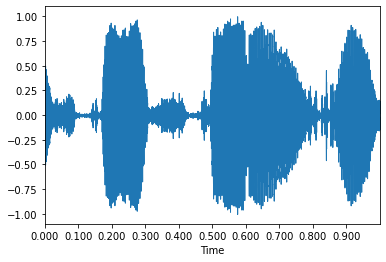

In [13]:
from librosa import display
display.waveplot(x[0],sr = 11000)

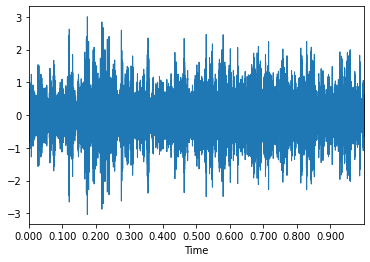

In [14]:
display.waveplot(y[0],sr =5500)

In [15]:
from scipy import signal
#new_y= signal.resample_poly(y[0], 2,1)
#print(x[0].shape)
#new_y.shape
testing = np.empty([9600,11000])

for i in range(len(y)):
  array = signal.resample_poly(y[i], 2, 1)
  testing[i] = array

print(testing.shape)

(9600, 11000)


In [16]:
batch = 1

X_train=signal2pytorch(x).to(device) #Convert to pytorch format, batch is first dimension    
X_test=signal2pytorch(testing).to(device) #Convert to pytorch format, batch is first dimension  


In [17]:
print("Clean sample: ", X_train.shape)
print("Noisy sample: ", X_test.shape)
print("test sample: ",test.shape)

Clean sample:  torch.Size([9600, 1, 11000])
Noisy sample:  torch.Size([9600, 1, 11000])
test sample:  (320, 5500)


In [18]:
print("Generate Model:")
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("Def. loss function:")
loss_fn = nn.MSELoss()  #MSE
#loss_fn = nn.L1Loss()
    
Ypred=model(X_train).to(device)
print("Ypred shape: ",Ypred.shape)
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X_train[:,:,:11000]  #the target signal with same length as model output
    
print("Input X.shape=", X_train.shape )
print("Target Y.shape=", Y.shape)
print("Ypred", Ypred.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())

Generate Model:
Total number of parameters: 131105
Def. loss function:
Ypred shape:  torch.Size([9600, 1, 11000])
outputlen= 11000
Input X.shape= torch.Size([9600, 1, 11000])
Target Y.shape= torch.Size([9600, 1, 11000])
Ypred torch.Size([9600, 1, 11000])
Target Y= tensor([[[ 2.6339e-01,  3.1440e-01,  3.7134e-01,  ...,  6.9590e-02,
          -3.7452e-02,  9.3727e-03]],

        [[-1.2816e-02, -7.2035e-03, -7.4184e-02,  ...,  6.7849e-01,
           6.3645e-01,  5.6645e-01]],

        [[-1.3548e-03, -9.9820e-03, -9.7577e-03,  ...,  3.1402e-02,
           9.4473e-02,  1.6907e-01]],

        ...,

        [[ 1.2849e-02,  8.5067e-03,  1.2540e-02,  ...,  2.7339e-01,
           1.8231e-01,  6.0176e-02]],

        [[ 2.3160e-01,  1.9259e-01,  2.2632e-01,  ...,  1.2303e-02,
           5.5118e-03,  1.6884e-02]],

        [[ 3.5254e-03,  2.5772e-04, -8.4731e-04,  ..., -4.7822e-02,
          -8.6330e-03, -5.6232e-02]]], device='cuda:0')
Y.type()= torch.cuda.FloatTensor


In [19]:
print(model)

Convautoenc(
  (conv1): Conv1d(1, 32, kernel_size=(2048,), stride=(32,), padding=(1012,))
  (synconv1): ConvTranspose1d(32, 1, kernel_size=(2048,), stride=(32,), padding=(1012,))
)


In [20]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
""";
    
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
outX_train=model(X_train)
#Ypred=Ypred.detach()
print("Ypred=", outX_train)
outX_train.to(device)
outX_train.to(device)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False
    
if randdir==True:
#optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X_train, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(1000):
        #distortions: shift and noise:

        """
        Xlast=X_train[:,:,-1].clone() 
        X_train[:,:,1:]=X_train[:,:,:-1].clone() #round Robbin, shift 1 right
        X_train[:,:,0]=Xlast.clone()
        Ylast=Y[:,:,-1].clone() 
        Y[:,:,1:]=Y[:,:,:-1].clone() #round Robbin, shift 1 right
        Y[:,:,0]=Ylast.clone()
      
        
        
        noise = torch.randn(X_train.size())*0.05
        noise = noise.to(device)"""

        Ypred=model(X_test)
        #print("Ypred.shape=", Ypred.shape)
        #loss wants batch in the beginning! (Batch, Classes,...)
        #Ypredp=Ypred.permute(1,2,0)
        #Yp=Y.permute(1,0)
        #print("Ypredp.shape=", Ypredp.shape, "Yp.shape=", Yp.shape )
        loss=loss_fn(Ypred, Y)
        if epoch%10==0:
            print(epoch, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Ypred= tensor([[[-0.0112,  0.0192,  0.0219,  ...,  0.1225, -0.0363,  0.0501]],

        [[ 0.0029,  0.0248,  0.0170,  ..., -0.1056,  0.0595,  0.0526]],

        [[-0.1079, -0.0337, -0.0660,  ...,  0.0291, -0.0123, -0.0104]],

        ...,

        [[ 0.0584,  0.1267, -0.0754,  ...,  0.0171,  0.0053,  0.0587]],

        [[-0.0212,  0.1156, -0.0481,  ...,  0.0157, -0.0023,  0.0094]],

        [[ 0.0159,  0.0121,  0.0154,  ..., -0.0063, -0.0042, -0.0018]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)
0 0.06828342378139496
10 0.05204811692237854
20 0.04157302901148796
30 0.03458176553249359
40 0.029489388689398766
50 0.025533588603138924
60 0.022388646379113197
70 0.019864829257130623
80 0.017828205600380898
90 0.016192644834518433
100 0.014891491271555424
110 0.013862432911992073
120 0.013049593195319176
130 0.012406150810420513
140 0.011894124560058117
150 0.011483387090265751
160 0.011150538921356201
170 0.010877740569412708
180 0.010651569813489914
190 0.010461968369781971


ww= OrderedDict([('conv1.weight', tensor([[[ 0.0058,  0.0015, -0.0034,  ...,  0.0161, -0.0067, -0.0017]],

        [[ 0.0011,  0.0024, -0.0128,  ..., -0.0022, -0.0114,  0.0149]],

        [[-0.0045,  0.0091, -0.0187,  ..., -0.0056,  0.0032,  0.0008]],

        ...,

        [[ 0.0034, -0.0085,  0.0119,  ...,  0.0099,  0.0102, -0.0125]],

        [[-0.0003, -0.0025,  0.0062,  ..., -0.0106,  0.0041, -0.0055]],

        [[-0.0091, -0.0034, -0.0031,  ..., -0.0018, -0.0002,  0.0067]]])), ('conv1.bias', tensor([ 0.0124, -0.0029, -0.0106, -0.0009, -0.0112,  0.0013, -0.0020,  0.0005,
         0.0060, -0.0067,  0.0012,  0.0022, -0.0075,  0.0024,  0.0096,  0.0029,
         0.0091,  0.0104,  0.0004, -0.0075, -0.0020,  0.0018, -0.0089,  0.0019,
         0.0031,  0.0120, -0.0060,  0.0041, -0.0059,  0.0115,  0.0035,  0.0054])), ('synconv1.weight', tensor([[[-0.0079, -0.0055, -0.0122,  ...,  0.0195,  0.0204, -0.0093]],

        [[-0.0095,  0.0016,  0.0018,  ..., -0.0020, -0.0087, -0.0051]],

        

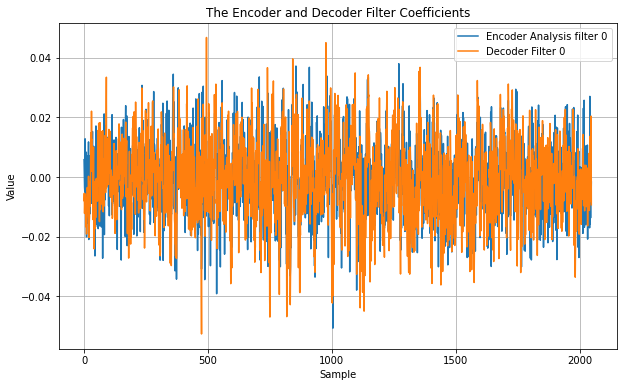

In [21]:
ww = model.cpu().state_dict()
 #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

predictions.shape= (9600, 1, 11000)


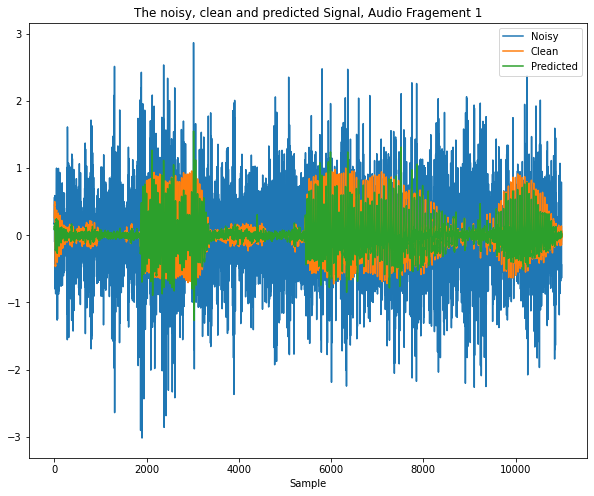

In [46]:
#Test on training set:
X_test =signal2pytorch(testing).to(device)
model=model.to(device)
#Xnoise=torch.cat((torch.zeros(1,1,100), Xnoise),dim=-1)
predictions=model(X_test) # Make Predictions based on the obtained weights, on training set
predictions=predictions.detach()
predictions=predictions.cpu()
predictions=np.array(predictions)
try: 
  Y=np.array(Y) 
except TypeError as TE:
  Y=np.array(Y.cpu())
#target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,8))
for b in range(1):
    plt.plot(np.array(X_test[b,0,:].cpu()))
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    #plt.plot(np.array(outX_train[b].detach().cpu()))
    plt.legend(('Noisy','Clean', 'Predicted'))
    plt.title('The noisy, clean and predicted Signal, Audio Fragement '+str(b+1))
    plt.xlabel('Sample')
    plt.show()

X_test=X_test.detach()
X_test = X_test.cpu()
X_test=np.array(X_test)
X_test=X_test[:,0,:]
#xnoise=np.transpose(xnoise)
#xnoise=np.clip(xnoise, -1.0,1.0)
    
xrek=predictions[:,0,:]  #remove unnecessary dimension for playback
#xrek=np.transpose(xrek)
#xrek=np.clip(xrek, -1.0,1.0)


In [23]:
IPython.display.Audio(X_test[0], rate = x.shape[1])

In [24]:
IPython.display.Audio(predictions[0], rate = x.shape[1])

In [25]:
IPython.display.Audio(x[0], rate = x.shape[1])

In [26]:
X_train.shape

torch.Size([9600, 1, 11000])

In [27]:
outX_train.shape

torch.Size([9600, 1, 11000])

In [28]:
predictions.shape

(9600, 1, 11000)

In [29]:
IPython.display.Audio(np.array(outX_train[0].detach().cpu()), rate = x.shape[1])

In [30]:
evaluate(np.array(Ypred.detach().cpu()),predictions)

(3.6582823e-10, 1.26780305e-05, 78.23132514953613)

In [31]:
def evaluate(clean, denoised):
    """"
    This function compares two set of signals by calculating the MSE (Mean squared error), MAE (Mean absolute error),
    and SNR (signal to noise ratio) in db averaged over all the signals.
    Receives two matrices of shape N, D. That correspond to N signals of length D.
    clean: a 2D numpy array containing the clean (original) signals.
    denoised: a 2D numpy array containing the denoised (reconstructed) versions of the original signals.
    """

    #MSE and MAE
    se = ((denoised - clean) ** 2).mean(-1)
    mse = se.mean()
    mae = np.abs(denoised - clean).mean(-1).mean()

    #SNR and PSNR
    num = (clean**2).sum(-1)
    den = ((denoised - clean) ** 2).sum(-1)
    ep = 1e-9
    SNR = 20*np.log10(np.sqrt(num)/(np.sqrt(den) + ep)).mean()

    return np.format_float_positional(mse, trim='-'), np.format_float_positional(mae, trim='-'), SNR

In [32]:

noisy = np.empty([test.shape[0],11000])
print(noisy.shape)
print(test.shape)

for i in range(test.shape[0]):
  noisy[i]  = signal.resample_poly(test[i], 2, 1)

print(noisy.shape)

(320, 11000)
(320, 5500)
(320, 11000)


In [33]:
testset =signal2pytorch(noisy).to(device) #Convert to pytorch format, batch is first dimension    
print("test sample: ",noisy.shape)
model.load_state_dict(ww)
model.eval()

#model.load_state_dict(torch.load(PATH))


ans = model(testset)

test sample:  (320, 11000)


In [34]:
ans.shape

torch.Size([320, 1, 11000])

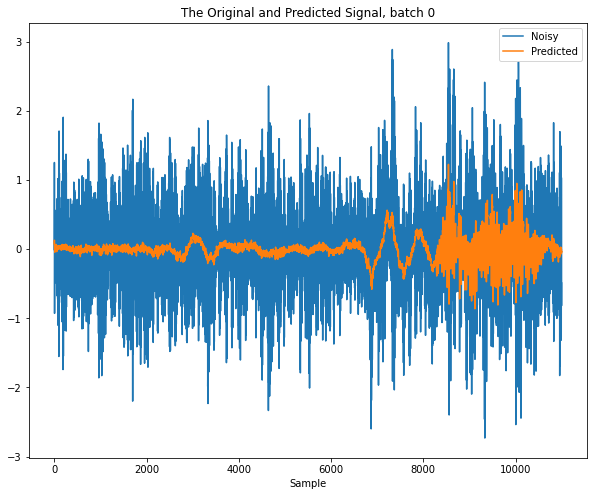

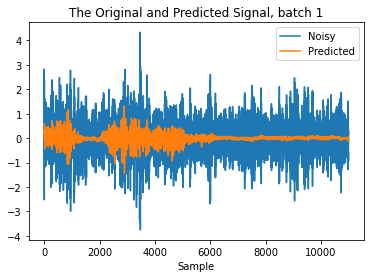

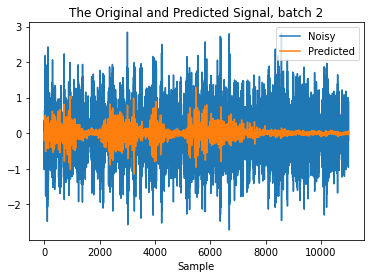

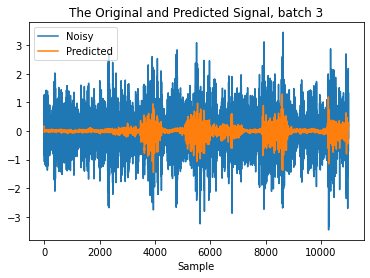

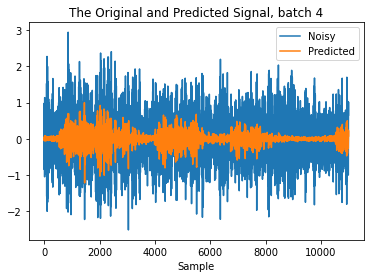

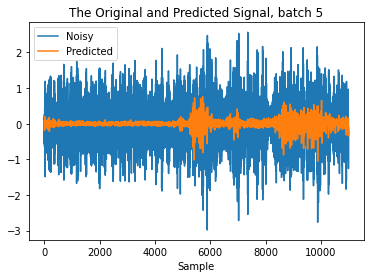

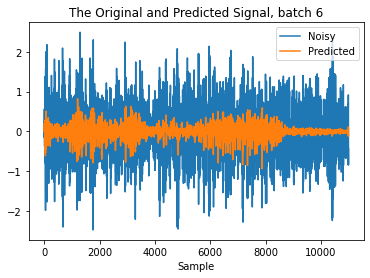

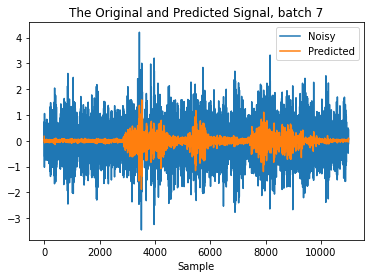

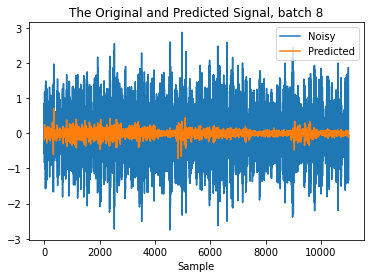

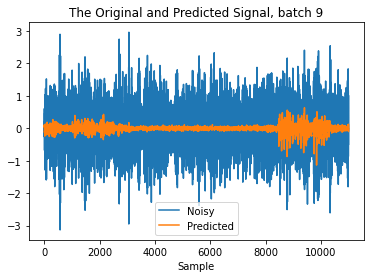

In [47]:

plt.figure(figsize=(10,8))
for b in range(10):
    plt.plot(np.array(testset[b,0,:].cpu()))
    plt.plot(ans[b,0,:].detach().cpu())
    plt.legend(('Noisy','Predicted'))
    plt.title('The Noisy and Predicted Signal of the testset, Audio Fragment '+str(b+1))
    plt.xlabel('Sample')
    plt.show()
xrek=predictions[:,0,:]

In [36]:
IPython.display.Audio(noisy[1], rate = x.shape[1])

In [37]:
IPython.display.Audio(ans.detach().cpu()[0], rate = x.shape[1])

In [38]:
output = np.array(ans.detach().cpu())
output = np.reshape(output, (320,11000))

In [75]:
output.shape

(320, 11000)

In [107]:
import zipfile

In [106]:
with open('answer.txt', 'w') as fp:
    pass

In [108]:
from tqdm import tqdm


with open("answer.txt", 'w+') as r:
  string = ""
  for audio in output:
    for sound in audio:
      string += str(sound) + ";"
    string += '\n'
  r.write(string)




In [109]:

with zipfile.ZipFile('answer.zip','w',zipfile.ZIP_DEFLATED) as myzip:
  myzip.write('answer.txt')


In [103]:
new = ''
for audio in output[:3]:

  for sound in audio:
    new += str(sound) + ';'
  new += '\n'

In [104]:
sub = []
for strin in new:
  sub.append(

'0.075054854;0.10011381;0.12780857;0.059572503;0.025389986;0.009785533;-0.0011479312;-0.015408661;-0.023787867;-0.037763126;-0.045156665;0.002980793;0.013848126;0.007035902;-0.008004356;0.034851264;0.03873005;0.019106911;0.0068355026;0.004295081;-0.010142949;-0.011096092;-0.0017803155;-0.0037331942;-0.015701544;0.001414998;0.0147079835;0.02069078;0.017809121;0.030369943;0.03901411;0.04264278;0.03983685;0.04416096;0.0493465;0.051606745;0.06803425;0.0465007;0.04347311;0.055867095;0.05467555;0.03723166;0.02158509;0.024894457;0.014199127;0.008559459;0.022495972;0.014685774;-0.00740833;-0.008646591;-0.0044430383;-0.017669234;-0.037049938;-0.032977153;-0.022432897;-0.019660683;-0.017018305;-0.019353947;-0.0040868092;-0.0050781537;0.009170658;-0.0012720076;0.0012377382;0.007345686;-0.0022559173;0.00096990145;0.0004890533;0.0126974685;0.022413732;0.015954588;0.032849487;0.02984607;0.043571502;0.022408675;0.025884721;0.03429414;0.038610492;0.022114402;0.013911269;0.01819519;0.018258153;0.012694

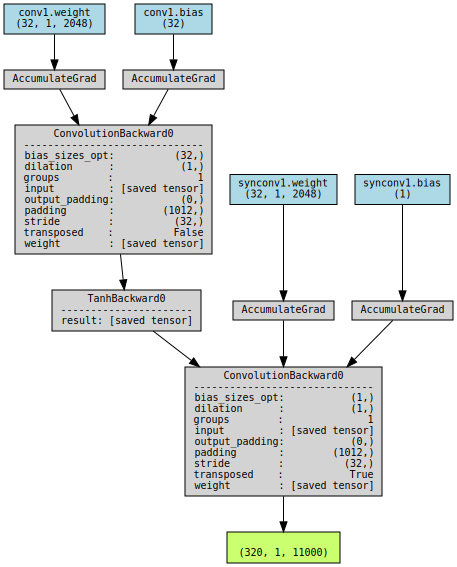

In [52]:
from torchviz import make_dot

make_dot(model(testset), params=dict(model.named_parameters()),show_attrs=True)



In [44]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep Learning Course/new_weights')

In [63]:
submission_class = np.array([3200,11000])

In [64]:
for line in 
submission_class.append([float(c_c) for c_c in c_line.split(";")])

AttributeError: ignored